In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy as cp
sns.set_theme()

np.random.seed(1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

## Exercise 1

In [2]:
class Function:
    
    def __init__(self, value, gradient):
        self.value = value
        self.gradient = gradient
        

In [3]:
val = lambda x: (x[0] - 6)**2+x[1]**2-x[0]*x[1] 
grad = lambda x: np.array((2*x[0]-x[1]-12, -x[0]+2*x[1]))
func = Function(val, grad)

In [4]:
func.value(np.array([6,6]))

0

In [5]:
func.gradient(np.array([6,6]))

array([-6,  6])

In [6]:
class GradientDescentOptimizer:
    
    def __init__(self, x0, func, max_steps, alpha):
        self.x = x0
        self.v = func.value(x0)
        self.func = func
        self.max_steps = max_steps
        self.alpha = alpha
        
    def optimize(self, verbose=False):
        for i in range(self.max_steps):
            self.x = self.x - self.alpha * self.func.gradient(self.x)
            v_new = self.func.value(self.x)
            if self.v - v_new < 1e-4:
                break
            
            if verbose:
                print(i, self.x.round(5), f'{self.v:.5f}', f'{v_new:.5f}')
            
            self.v = v_new
            

In [7]:
gdo = GradientDescentOptimizer(np.array([6,6]), func, 10, 0.1)
gdo.optimize(verbose=True)
gdo.x

0 [6.60000 5.40000] 0.00000 -6.12000
1 [7.02000 4.98000] -6.12000 -9.11880
2 [7.31400 4.68600] -9.11880 -10.58821
3 [7.51980 4.48020] -10.58821 -11.30822
4 [7.66386 4.33614] -11.30822 -11.66103
5 [7.76470 4.23530] -11.66103 -11.83390
6 [7.83529 4.16471] -11.83390 -11.91861
7 [7.88470 4.11530] -11.91861 -11.96012
8 [7.91929 4.08071] -11.96012 -11.98046
9 [7.94350 4.05650] -11.98046 -11.99042


array([7.94350, 4.05650])

## Exercise 3

#### Training data

In [8]:
train_data = pd.DataFrame(data=np.array([[0,1,0,-1,0],[0,0,-1,0,1],[1,0,0,0,0]]).T, columns=['x1','x2','y'] )

In [9]:
train_data

,x1,x2,y
0,0,0,1
1,1,0,0
2,0,-1,0
3,-1,0,0
4,0,1,0


#### Activation / loss functions

In [10]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def binary_cross_entropy(f_out, y):
    return -(y*np.log(f_out + 1e-15)+(1-y)*np.log(1-f_out + 1e-15))

#### Main NeuralNetwork class

In [11]:
class NeuralNetwork:
    def __init__(self, params, data):
        self.parameters = params
        self.data = data
    
    @property
    def parameters(self):
        return np.array([self.b1, self.b2, self.w11, self.w12, self.w21, self.w22, self.c, self.u1, self.u2])
  
    @parameters.setter
    def parameters(self, params):
        self.b1 = params[0]
        self.b2 = params[1]
        self.w11 = params[2]
        self.w12 = params[3]
        self.w21 = params[4]
        self.w22 = params[5]
        self.c = params[6]
        self.u1 = params[7]
        self.u2 = params[8] 
        
    def predict(self, prediction_data=None):
        if prediction_data is not None:
            this_data = prediction_data
        else:
            prediction_data = self.data
        self.z1in = self.b1 + prediction_data.x1 * self.w11 + prediction_data.x2 * self.w21
        self.z1out = np.tanh(self.z1in)
        self.z2in = self.b2 + prediction_data.x1 * self.w12 + prediction_data.x2 * self.w22
        self.z2out = np.tanh(self.z2in)
        self.fin = self.c + self.u1 * self.z1out + self.u2 * self.z2out
        self.fout = sigmoid(self.fin)

        return self.fout
    
    def loss(self):
        preds = self.predict()
        return np.mean(binary_cross_entropy(preds, self.data.y))
    
    def gradient(self):
        # now we start back-propagation through the loss and the output neuron
        dL_dfout = -self.data.y / (self.fout + 1e-15) + (1 - self.data.y) / (1 - self.fout + 1e-15)
        dfout_dfin = sigmoid(self.fin) * (1 - sigmoid(self.fin))
        
        # compute the gradients for the parameters of the output layer
        dfin_dc = 1
        dfin_du1 = self.z1out
        dfin_du2 = self.z2out
        
        # take the mean gradient across data points
        dL_dc = np.mean(dL_dfout * dfout_dfin * dfin_dc)
        dL_du1 = np.mean(dL_dfout * dfout_dfin * dfin_du1)
        dL_du2 = np.mean(dL_dfout * dfout_dfin * dfin_du2)
        
        # back-propagate through the neurons in the first hidden layer
        dfin_dz1out = self.u1
        dfin_dz2out = self.u2
        dz1out_dz1in = 1 - np.tanh(self.z1in)**2
        dz2out_dz2in = 1 - np.tanh(self.z2in)**2
        
        # and compute the derivatives of the parameters of the hidden layer
        dz1in_db1 = dz2in_db2 = 1
        dL_db1 = np.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_db1)
        dL_db2 = np.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_db2)
        dz1in_dw11 = self.data.x1
        dz2in_dw12 = self.data.x1
        dL_dw11 = np.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_dw11)
        dL_dw12 = np.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_dw12)
        dz1in_dw21 = self.data.x2
        dz2in_dw22 = self.data.x2
        dL_dw21 = np.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_dw21)
        dL_dw22 = np.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_dw22)

        return np.array([dL_db1, dL_db2, dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_dc, dL_du1, dL_du2])
        
    def train(self, verbose=False):
        max_steps = 100
        alpha = 1
        
        for i in range(max_steps):
            
            #forward pass
            old_loss = self.loss()
            
            #backpropagation step
            current_parameters = self.parameters
            self.parameters = current_parameters - alpha * self.gradient()
            
            new_loss = self.loss()
            
            if verbose:
                print(i, f'{old_loss:.5f}', f'{new_loss:.5f}')
            
            if old_loss - new_loss < 1e-4:
                break
            
        return new_loss
        

#### Initialize network randomly

In [12]:
params = np.random.randn(9)
nnet = NeuralNetwork(params,train_data)

#### Check prediction function

In [13]:
nnet.predict()

0    0.704019
1    0.698192
2    0.825680
3    0.757939
4    0.663033
dtype: float64

#### Check loss function

In [14]:
nnet.loss()

1.1604226359847671

#### Check gradient function

In [15]:
nnet.gradient()

array([-0.11488, 0.03905, -0.03235, -0.03365, 0.07140, -0.00622, 0.52977,
       0.44092, -0.01029])

In [16]:
# first, compute the analytical gradient of the parameters
gradient = nnet.gradient()
eps = 1e-9
for i in range(9):
    # compute loss when subtracting eps to parameter i
    neg_params = cp(params)
    neg_params[i] = neg_params[i] - eps
    nnet_neg = NeuralNetwork(neg_params, train_data)
    neg_value = nnet_neg.loss()
    
    # compute loss when adding eps to parameter i
    pos_params = cp(params)
    pos_params[i] = pos_params[i] + eps
    nnet_pos = NeuralNetwork(pos_params, train_data)
    pos_value = nnet_pos.loss()
    
    # compute the "empirical" gradient of parameter i
    fdiff_gradient = np.mean((pos_value - neg_value) / (2 * eps));
    
    # error if difference is too large
    assert abs(gradient[i] - fdiff_gradient) < 1e-5

print("Gradients are correct!")

Gradients are correct!


#### Train the network

In [17]:
nnet.train(verbose=True)

0 1.16042 0.75548
1 0.75548 0.60711
2 0.60711 0.55388
3 0.55388 0.53039
4 0.53039 0.51761
5 0.51761 0.50945
6 0.50945 0.50362
7 0.50362 0.49912
8 0.49912 0.49543
9 0.49543 0.49229
10 0.49229 0.48952
11 0.48952 0.48700
12 0.48700 0.48465
13 0.48465 0.48244
14 0.48244 0.48032
15 0.48032 0.47827
16 0.47827 0.47628
17 0.47628 0.47434
18 0.47434 0.47244
19 0.47244 0.47057
20 0.47057 0.46874
21 0.46874 0.46695
22 0.46695 0.46520
23 0.46520 0.46347
24 0.46347 0.46178
25 0.46178 0.46012
26 0.46012 0.45850
27 0.45850 0.45691
28 0.45691 0.45534
29 0.45534 0.45381
30 0.45381 0.45231
31 0.45231 0.45084
32 0.45084 0.44940
33 0.44940 0.44798
34 0.44798 0.44660
35 0.44660 0.44524
36 0.44524 0.44391
37 0.44391 0.44260
38 0.44260 0.44133
39 0.44133 0.44008
40 0.44008 0.43886
41 0.43886 0.43766
42 0.43766 0.43649
43 0.43649 0.43535
44 0.43535 0.43424
45 0.43424 0.43315
46 0.43315 0.43208
47 0.43208 0.43104
48 0.43104 0.43002
49 0.43002 0.42903
50 0.42903 0.42806
51 0.42806 0.42712
52 0.42712 0.42620
53 

0.3987548189416419

#### Train multiple networks to find best parameterization

In [18]:
min_loss = np.inf
random_initializations = 10

best_parameters = None

for i in range(random_initializations):
    p = np.random.randn(9)
    nn = NeuralNetwork(p, train_data)
    final_loss = nn.train()
    print(f'Loss: {final_loss:.5f}{" *" if final_loss < 0.1 else ""}')
    if final_loss < min_loss:
        min_loss = final_loss
        best_parameters = p

Loss: 0.40950
Loss: 0.50214
Loss: 0.36548
Loss: 0.44099
Loss: 0.09532 *
Loss: 0.11540
Loss: 0.05380 *
Loss: 0.10543
Loss: 0.50139
Loss: 0.50192


#### Visualize best network

In [19]:
best_nn = NeuralNetwork(best_parameters, train_data)
best_nn.train()

0.05379924575790945

In [20]:
def get_plot_data():
    x_grid, y_grid = np.mgrid[-2:2:1/25, -2:2:1/25]
    x_pos = x_grid.ravel()
    y_pos = y_grid.ravel()
    return np.array([x_pos,y_pos]).T

plot_data = pd.DataFrame(data=get_plot_data(), columns=['x1','x2'])

In [21]:
predictions = best_nn.predict(plot_data)

In [22]:
def plot_grid(predictions):
    plt.figure()
    sns.scatterplot(x=plot_data.x1,y=plot_data.x2, hue=predictions, marker="s",s=11)
    sns.scatterplot(x=train_data.x1,y=train_data.x2, hue=train_data.y, marker="s",s=20)
    plt.show()

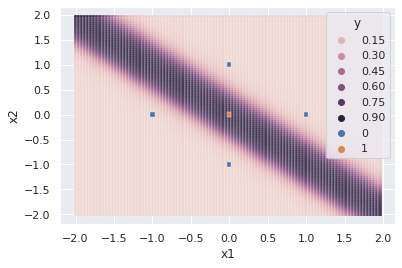

In [23]:
plot_grid(predictions)

#### Visualize random network

In [24]:
untrained_network = NeuralNetwork(np.random.randn(9), train_data)
predictions = untrained_network.predict(plot_data)

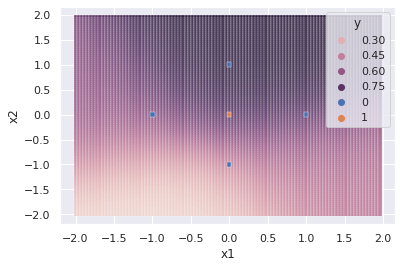

In [25]:
plot_grid(predictions)